In [1]:
import ee
import geemap

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AWtgzh49M55GkC4goOnLiy0ItbULPb8l8TytPwOMc-9paUa08avYASMsyyY

Successfully saved authorization token.


In [171]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)
    return ee.Feature(geometry, stat).set({'date': img.date().format('dd-MM-YYYY')})
  return reduce_region_function
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
          reducer=ee.Reducer.toList().repeat(prop_names.size()),
          selectors=prop_names).get('list')

    return ee.Dictionary.fromLists(prop_names, prop_lists)

In [272]:
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    swi = image.normalizedDifference(['B5', 'B11']).rename('SWI')
    return image.addBands(ndvi).addBands(ndwi).addBands(swi)

def addFWI(image):
    image_bands = image.select(['B3', 'B4', 'B8', 'B11', 'B12']).resample('bilinear').reproject(crs="EPSG:4283", scale=10)
    fwi = image_bands.expression('1.7204 + 171*B2 + 3*B3 -70*B4 -45*B5 - 71*B7',
                                {
                                    'B2':image_bands.select('B3'),
                                    'B3':image_bands.select('B4'),
                                    'B4':image_bands.select('B8'),
                                    'B5':image_bands.select('B11'),
                                    'B7':image_bands.select('B12')
                                })
    return(image.addBands(fwi.rename("FWI")))
    
def addTC(image):
    # Define array of Tasseled Cap coefficients
    coefficients = ee.Array([
    [  0.3037,  0.2793,  0.4743,  0.5585,  0.5082,  0.1863 ],
    [ -0.2848, -0.2435, -0.5436,  0.7243,  0.0840, -0.1800 ],
    [  0.1509,  0.1973,  0.3279,  0.3406, -0.7112, -0.4572 ],
    [ -0.8242,  0.0849,  0.4392, -0.0580,  0.2012, -0.2768 ],
    [ -0.3280,  0.0549,  0.1075,  0.1855, -0.4357,  0.8085 ],
    [  0.1084, -0.9022,  0.4120,  0.0573, -0.0251,  0.0238 ]
  ])

  # Select bands for use in Tasseled Cap
    image_bands_tc = image.select(['B', 'B3', 'B4', 'B8', 'B11', 'B12'])

  # Create 1-D array image (vector of length 6 for all bands per pixel)
    array_image_1d = image_bands_tc.toArray()

  # Create 2-D array image (6x1 matrix for all bands per pixel) from 1-D array
    array_image_2d = array_image_1d.toArray(1)
    
    components_image = ee.Image(coefficients) \
        .matrixMultiply(array_image_2d) \
        .arrayProject([0]) \
        .arrayFlatten([['brightness', 'greenness', 'wetness', 'fourth', 'fifth', 'sixth']])

    return components_image

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import json
%matplotlib inline
zones = open('C:\\Users\\Liam\\Downloads\\aoi.geojson')
zones = json.load(zones)




In [278]:
#ext = ee.Geometry.Polygon([[[143.507, -34.618],[143.507, -34.746],[143.683, -34.746],[143.683, -34.618]]])
ext = ee.Geometry.Polygon([[[143.967, -34.242],[143.967, -34.296],[144.067, -34.296],[144.067, -34.242]]])
outdf = 1
for i in range(0,8):
    stat_zone = ee.Geometry.Polygon(zones["features"][i]["geometry"]["coordinates"][0])
    ic = ee.ImageCollection('COPERNICUS/S2_SR')\
            .filterMetadata('MGRS_TILE', 'equals', '55HBC')\
            .filterDate('2019-01-01','2023-01-30')\
            .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 50))\
            .map(lambda img: img.clip(ext)).filterBounds(ext)\
            .map(addNDVI).map(addFWI)
    reduce_im = create_reduce_region_function(geometry = stat_zone,reducer=ee.Reducer.mean(),scale=10,crs='EPSG:4283')
    ndv_stat = ee.FeatureCollection(ic.select(['B8A','B12','NDWI','NDVI','FWI','SWI','MSK_CLDPRB']).map(reduce_im).filter(ee.Filter.neq('NDVI', None)))
    ndvi_dict = fc_to_dict(ndv_stat).getInfo()
    ndvi_df = pd.DataFrame(ndvi_dict)
    ndvi_df['object'] = i
    if type(outdf) == int:
        outdf = ndvi_df
    else:
        outdf = outdf.append(ndvi_df)
outdf.to_csv("response.csv")
    

In [268]:
ndvi_dict = fc_to_dict(ndv_stat).getInfo()
ndvi_df = pd.DataFrame(ndvi_dict)
display(ndvi_df)

,B12,B8A,FWI,MSK_CLDPRB,NDVI,NDWI,SWI,date,system:index
0,1533.828124,3503.818699,-27.868053,0.0,0.534513,-0.552863,-0.285076,01-01-2019,20190101T002051_20190101T002048_T55HBC
1,1304.664062,3185.674389,-25.041137,0.0,0.550358,-0.568469,-0.292735,04-01-2019,20190104T002701_20190104T002702_T55HBC
2,1518.716367,3641.254025,-30.750273,0.0,0.579714,-0.596296,-0.298868,06-01-2019,20190106T002059_20190106T002053_T55HBC
3,1357.349839,3265.159585,-28.218380,0.0,0.589698,-0.619951,-0.312289,09-01-2019,20190109T002709_20190109T003549_T55HBC
4,1438.209731,3603.934383,-29.584290,0.0,0.577320,-0.594942,-0.282263,11-01-2019,20190111T002051_20190111T002050_T55HBC
...,...,...,...,...,...,...,...,...,...
418,1833.222846,5555.459358,-33.187290,0.0,0.594978,-0.520097,-0.185365,13-01-2023,20230113T002711_20230113T003421_T55HBC
419,1911.118197,5692.237886,-33.669908,0.0,0.588644,-0.510551,-0.205235,15-01-2023,20230115T002049_20230115T002358_T55HBC
420,1899.831658,5751.431556,-34.973275,0.0,0.603568,-0.524493,-0.188703,20-01-2023,20230120T002051_20230120T002339_T55HBC
421,1826.833464,5460.602568,-32.286361,0.0,0.587357,-0.513799,-0.183226,23-01-2023,20230123T002701_20230123T003341_T55HBC


In [277]:
type(outdf)

pandas.core.frame.DataFrame

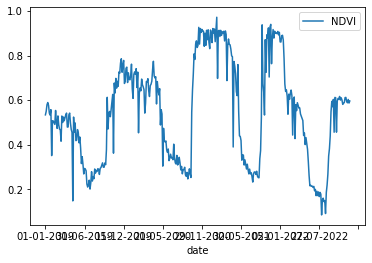

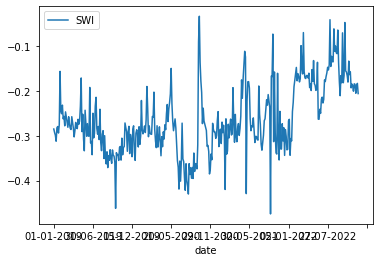

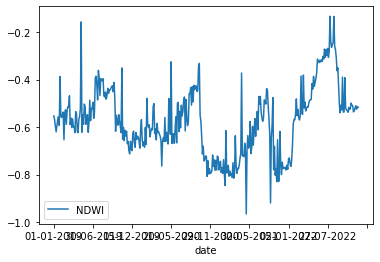

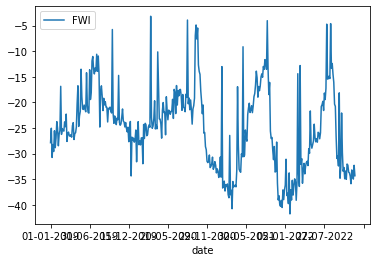

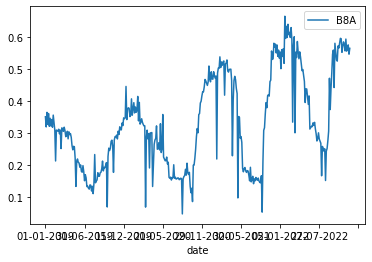

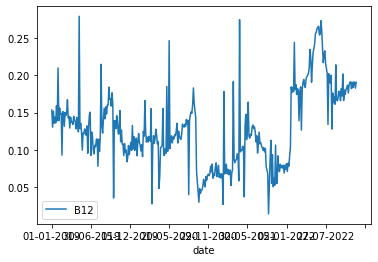

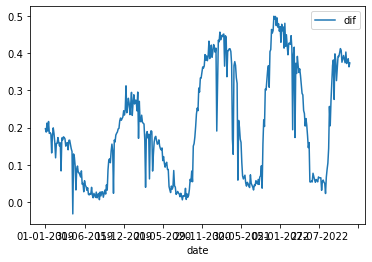

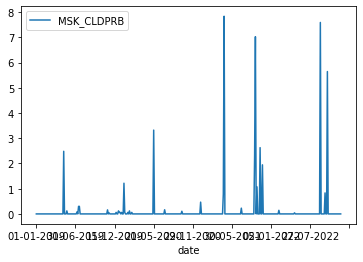

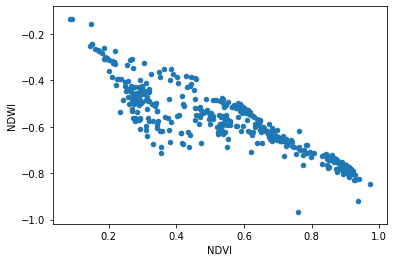

In [271]:
ndvi_df = ndvi_df[ndvi_df["MSK_CLDPRB"]<10]
#ndvi_df['B8A'] = ndvi_df['B8A']/10000
#ndvi_df['B12'] = ndvi_df['B12']/10000
ndvi_df['dif'] = ndvi_df['B8A'] - ndvi_df['B12']
ndvi_df.plot(y='NDVI',x = 'date' )
ndvi_df.plot(y='SWI', x = 'date')
ndvi_df.plot(y='NDWI', x = 'date')
ndvi_df.plot(y='FWI', x = 'date')
ndvi_df.plot(y='B8A', x = 'date')
ndvi_df.plot(y='B12', x = 'date')
ndvi_df.plot(y='dif', x = 'date')
ndvi_df.plot(y='MSK_CLDPRB', x = 'date')
ndvi_df.plot.scatter(x='NDVI',y='NDWI')

In [136]:
ic.select('NDVI').size()

In [137]:
type(0.2874)

float